# Dự án NLP: Phân loại Văn bản Tiếng Việt

Notebook này triển khai quy trình hoàn chỉnh để phân loại tin tức tiếng Việt thành 20 chủ đề khác nhau.

**Quy trình thực hiện:**
1.  **Tải & Tiền xử lý dữ liệu:** Chuẩn hóa Unicode, tách từ (tokenization), loại bỏ từ dừng (stopwords).
2.  **Mô hình Machine Learning cơ bản:** Naive Bayes, Logistic Regression, SVM (LinearSVC).
3.  **Mô hình Deep Learning:** LSTM (Long Short-Term Memory).
4.  **Mô hình Deep Learning 2:** TextCNN (Convolutional Neural Networks).
5.  **Đánh giá & Dự đoán:** Xuất báo cáo hiệu năng và hệ thống dự đoán thời gian thực.

In [1]:
# 1. THIẾT LẬP MÔI TRƯỜNG & THƯ VIỆN
import os
import gc
import joblib
import shutil
import unicodedata
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from collections import Counter
from tqdm import tqdm

# PyTorch & Transformers
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW

# Scikit-Learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.calibration import CalibratedClassifierCV

# Matplotlib & Seaborn
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# Thư viện xử lý tiếng Việt
from pyvi import ViTokenizer

# Cấu hình đường dẫn
CURRENT_DIR = Path.cwd()
PROJECT_ROOT = CURRENT_DIR if (CURRENT_DIR / "data").exists() else CURRENT_DIR.parent

DATA_DIR = PROJECT_ROOT / "data" / "final"
MODEL_DIR = PROJECT_ROOT / "models"
REPORT_DIR = PROJECT_ROOT / "reports"
JSONL_PATH = DATA_DIR / "nlp_dataset.jsonl"

# Tạo thư mục nếu chưa tồn tại
for d in [MODEL_DIR, REPORT_DIR]:
    d.mkdir(parents=True, exist_ok=True)

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Thiết bị đang sử dụng: {DEVICE}")

Thiết bị đang sử dụng: cuda


In [2]:
# 2. TẢI VÀ TIỀN XỬ LÝ DỮ LIỆU

STOPWORD_PATH = PROJECT_ROOT / "data" / "final" / "vietnamese-stopwords-dash.txt"

def load_stopwords(filepath):
    try:
        with open(filepath, 'r', encoding='utf-8') as f:
            return set([line.strip() for line in f.readlines()])
    except FileNotFoundError:
        print(f"Lỗi: Không tìm thấy file stopwords tại {filepath}")
        return {"thì", "là", "mà"}

STOPWORDS = load_stopwords(STOPWORD_PATH)
print(f"Đã tải {len(STOPWORDS)} từ dừng.")

def normalize_text(text):
    return unicodedata.normalize('NFC', text)

def preprocess_text(text):
    text = normalize_text(text)
    tokenized = ViTokenizer.tokenize(text)
    words = tokenized.split()
    clean_words = [w for w in words if w.lower() not in STOPWORDS]
    return " ".join(clean_words)

if JSONL_PATH.exists():
    print("Đang tải dữ liệu từ file JSONL...")
    df = pd.read_json(JSONL_PATH, lines=True)
    
    if 'raw_text' not in df.columns:
        df['raw_text'] = df['text'].apply(normalize_text)
    
    print("Đang xử lý tách từ và lọc stopwords...")
    tqdm.pandas(desc="Xử lý văn bản")
    df['text'] = df['raw_text'].progress_apply(preprocess_text)
    
    df.to_json(JSONL_PATH, orient="records", lines=True)
else:
    print("Lỗi: Không tìm thấy file dữ liệu.")

target_col = 'label_name'
if target_col not in df.columns and 'label' in df.columns:
    df[target_col] = df['label']

le = LabelEncoder()
df['label_id'] = le.fit_transform(df[target_col])
classes = le.classes_
num_classes = len(classes)

train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df[target_col])

print(f"Số lượng Train: {len(train_df)} | Số lượng Test: {len(test_df)}")
print(f"Danh sách {num_classes} nhãn: {classes}")

del df
gc.collect()

Đã tải 1942 từ dừng.
Đang tải dữ liệu từ file JSONL...
Đang xử lý tách từ và lọc stopwords...


Xử lý văn bản: 100%|██████████| 115188/115188 [25:09<00:00, 76.33it/s] 


Số lượng Train: 92150 | Số lượng Test: 23038
Danh sách 20 nhãn: ['Bất động sản' 'Chứng khoán' 'Công nghệ' 'Du lịch' 'Gia đình'
 'Giao thông' 'Giáo dục' 'Giải trí' 'Khoa học' 'Khởi nghiệp' 'Kinh doanh'
 'Nông nghiệp' 'Pháp luật' 'Sức khỏe' 'Thế giới' 'Thể thao'
 'Thời sự – Chính trị' 'Văn hóa' 'Đời sống' 'Ẩm thực']


0

# 3. MÔ HÌNH MACHINE LEARNING CƠ BẢN

In [3]:
# Tạo đặc trưng TF-IDF
print("Đang tạo vector TF-IDF...")
tfidf = TfidfVectorizer(max_features=20000, ngram_range=(1, 2))
X_train = tfidf.fit_transform(train_df['text'])
X_test = tfidf.transform(test_df['text'])

# 1. Naive Bayes
print("Đang huấn luyện Naive Bayes...")
nb = MultinomialNB()
nb.fit(X_train, train_df['label_id'])
acc_nb = accuracy_score(test_df['label_id'], nb.predict(X_test))
print(f"Naive Bayes Accuracy: {acc_nb:.4f}")

# 2. Logistic Regression
print("Đang huấn luyện Logistic Regression...")
lr = LogisticRegression(max_iter=1000, random_state=42, n_jobs=-1)
lr.fit(X_train, train_df['label_id'])
acc_lr = accuracy_score(test_df['label_id'], lr.predict(X_test))
print(f"Logistic Regression Accuracy: {acc_lr:.4f}")

# 3. SVM (LinearSVC) 
print("Đang huấn luyện SVM (LinearSVC) với chế độ chuẩn hóa xác suất...")
linear_svc = LinearSVC(dual=False, random_state=42, max_iter=1000)
svm = CalibratedClassifierCV(linear_svc, method='sigmoid', cv=5) 
svm.fit(X_train, train_df['label_id'])
acc_svm = accuracy_score(test_df['label_id'], svm.predict(X_test))
print(f"SVM (Calibrated) Accuracy: {acc_svm:.4f}")

Đang tạo vector TF-IDF...
Đang huấn luyện Naive Bayes...
Naive Bayes Accuracy: 0.7854
Đang huấn luyện Logistic Regression...
Logistic Regression Accuracy: 0.8347
Đang huấn luyện SVM (LinearSVC) với chế độ chuẩn hóa xác suất...
SVM (Calibrated) Accuracy: 0.8420


# 4. DEEP LEARNING (LSTM)

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from collections import Counter
from tqdm import tqdm
from sklearn.metrics import accuracy_score

print("⏳ Đang huấn luyện mô hình LSTM...")

# 1. Xây dựng Vocabulary
counter = Counter()
for t in train_df['text']: 
    counter.update(t.split())

vocab = {w: i+2 for i, (w, _) in enumerate(counter.most_common(20000))}
vocab['<PAD>'] = 0
vocab['<UNK>'] = 1
MAX_LEN_LSTM = 800 # Nếu báo lỗi bộ nhớ (OOM) thì giảm xuống 300-500

def text_to_seq(text, vocab, max_len):
    seq = [vocab.get(w, 1) for w in text.split()]
    if len(seq) < max_len:
        seq += [0] * (max_len - len(seq))
    return seq[:max_len]

# --- SỬA LỖI TẠI ĐÂY (CLASS DATASET) ---
class LSTMDataset(Dataset):
    def __init__(self, df): 
        self.x = [text_to_seq(t, vocab, MAX_LEN_LSTM) for t in df['text']]
        self.y = df['label_id'].values
    
    def __len__(self): 
        return len(self.y)
    
    def __getitem__(self, idx): 
        # Quan trọng: Thêm dtype=torch.long để ép kiểu sang int64
        return torch.tensor(self.x[idx], dtype=torch.long), torch.tensor(self.y[idx], dtype=torch.long)

# DataLoader
train_loader = DataLoader(LSTMDataset(train_df), batch_size=64, shuffle=True)
test_loader = DataLoader(LSTMDataset(test_df), batch_size=64)

# 2. Kiến trúc LSTM
class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_classes):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, num_layers=2, batch_first=True, dropout=0.3)
        self.fc = nn.Linear(hidden_dim, num_classes)
        self.dropout = nn.Dropout(0.3)
        
    def forward(self, x):
        embedded = self.embedding(x)
        output, (h_n, c_n) = self.lstm(embedded)
        # Lấy max pooling để hội tụ nhanh hơn
        out, _ = torch.max(output, dim=1) 
        out = self.dropout(out)
        out = self.fc(out)
        return out

# Khởi tạo model
# Lưu ý: Đảm bảo biến 'device' hoặc 'DEVICE' khớp với code bên trên của bạn
device_use = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_lstm = LSTMClassifier(len(vocab)+2, 128, 256, num_classes).to(device_use)
optimizer = optim.Adam(model_lstm.parameters(), lr=0.001, weight_decay=1e-5)
criterion = nn.CrossEntropyLoss()

# 3. Vòng lặp huấn luyện
for epoch in range(10):
    model_lstm.train()
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}")
    for x, y in pbar:
        # Ép kiểu thêm 1 lần nữa cho chắc chắn
        x, y = x.to(device_use, dtype=torch.long), y.to(device_use, dtype=torch.long)
        
        optimizer.zero_grad()
        loss = criterion(model_lstm(x), y)
        loss.backward()
        optimizer.step()
        
        pbar.set_postfix({'loss': f'{loss.item():.4f}'})

# 4. Đánh giá
model_lstm.eval()
preds_lstm = []
with torch.no_grad():
    for x, _ in test_loader:
        # Ép kiểu cho tập test
        x = x.to(device_use, dtype=torch.long)
        preds_lstm.extend(torch.argmax(model_lstm(x), dim=1).cpu().numpy())

acc_lstm = accuracy_score(test_df['label_id'], preds_lstm)
print(f"✅ LSTM Accuracy: {acc_lstm:.4f}")

⏳ Đang huấn luyện mô hình LSTM...


Epoch 10: 100%|██████████| 1440/1440 [04:06<00:00,  5.84it/s, loss=0.1577]


✅ LSTM Accuracy: 0.8259


# 5. DEEP LEARNING MODEL 2: TextCNN 

In [5]:

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
from sklearn.metrics import accuracy_score

print(" Đang huấn luyện mô hình TextCNN...")

# 1. ĐỊNH NGHĨA KIẾN TRÚC TextCNN
class TextCNN(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_classes, kernel_sizes=[2, 3, 4, 5, 6], num_filters=128):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        
        self.convs = nn.ModuleList([
            nn.Conv1d(in_channels=embed_dim, 
                      out_channels=num_filters, 
                      kernel_size=k) 
            for k in kernel_sizes
        ])
        
        self.bn = nn.BatchNorm1d(len(kernel_sizes) * num_filters)
        
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(len(kernel_sizes) * num_filters, num_classes)

    def forward(self, x):
        x = self.embedding(x) 
        x = x.permute(0, 2, 1) 
        
        # Conv -> ReLU -> MaxPool
        x_convs = [F.relu(conv(x)) for conv in self.convs]
        x_pools = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in x_convs]
        x_cat = torch.cat(x_pools, dim=1)
        x_cat = self.bn(x_cat)
        out = self.dropout(x_cat)
        return self.fc(out)

# 2. THIẾT LẬP & HUẤN LUYỆN
cnn_vocab_size = len(vocab) + 2 
cnn_embed_dim = 128
cnn_filters = 128
cnn_kernels = [2, 3, 4, 5] 

model_cnn = TextCNN(cnn_vocab_size, cnn_embed_dim, num_classes, cnn_kernels, cnn_filters).to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_cnn.parameters(), lr=0.001)

# Training Loop
train_loader_cnn = DataLoader(LSTMDataset(train_df), batch_size=64, shuffle=True)

for epoch in range(10): 
    model_cnn.train()
    total_loss = 0
    for x, y in tqdm(train_loader_cnn, desc=f"Epoch {epoch+1}/10"):
        x, y = x.to(DEVICE), y.to(DEVICE)
        optimizer.zero_grad()
        loss = criterion(model_cnn(x), y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

# 3. ĐÁNH GIÁ & LƯU MODEL
model_cnn.eval()
preds_cnn = []
with torch.no_grad():
    for x, _ in test_loader:
        out = model_cnn(x.to(DEVICE))
        preds_cnn.extend(torch.argmax(out, dim=1).cpu().numpy())

acc_cnn = accuracy_score(test_df['label_id'], preds_cnn)
print(f" TextCNN Accuracy: {acc_cnn:.4f}")

# Lưu Model
cnn_config = {
    'vocab_size': cnn_vocab_size,
    'embed_dim': cnn_embed_dim,
    'num_classes': num_classes,
    'kernels': cnn_kernels,
    'filters': cnn_filters,
    'max_len': MAX_LEN_LSTM
}
torch.save({
    'model_state': model_cnn.state_dict(),
    'config': cnn_config,
    'vocab': vocab
}, MODEL_DIR / "textcnn_model.pth")
print("💾 Đã lưu TextCNN model.")

 Đang huấn luyện mô hình TextCNN...


Epoch 10/10: 100%|██████████| 1440/1440 [00:20<00:00, 69.51it/s]


 TextCNN Accuracy: 0.8655
💾 Đã lưu TextCNN model.


# 6. ĐÁNH GIÁ & BÁO CÁO

Dang thu thap ket qua du doan...
Dang xuat Excel report: detailed_classification_report.xlsx


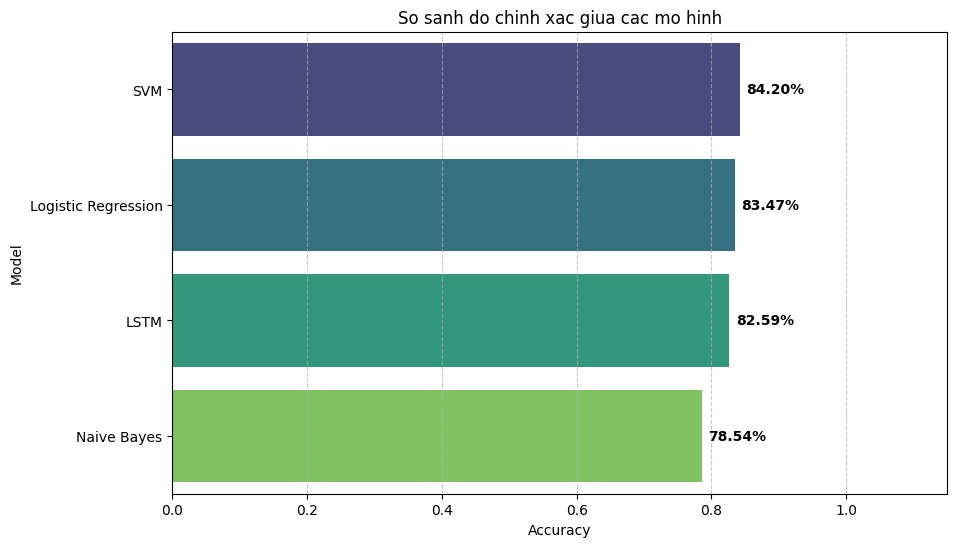

Bang Xep Hang Hieu Nang:


,Model,Accuracy
0,SVM,0.842044
1,Logistic Regression,0.834664
2,LSTM,0.825940
3,Naive Bayes,0.785441


Dang ve Confusion Matrix cho 4 mo hinh...
Dang luu cac mo hinh...
 - Da luu LSTM Model.
Hoan tat toan bo quy trinh!


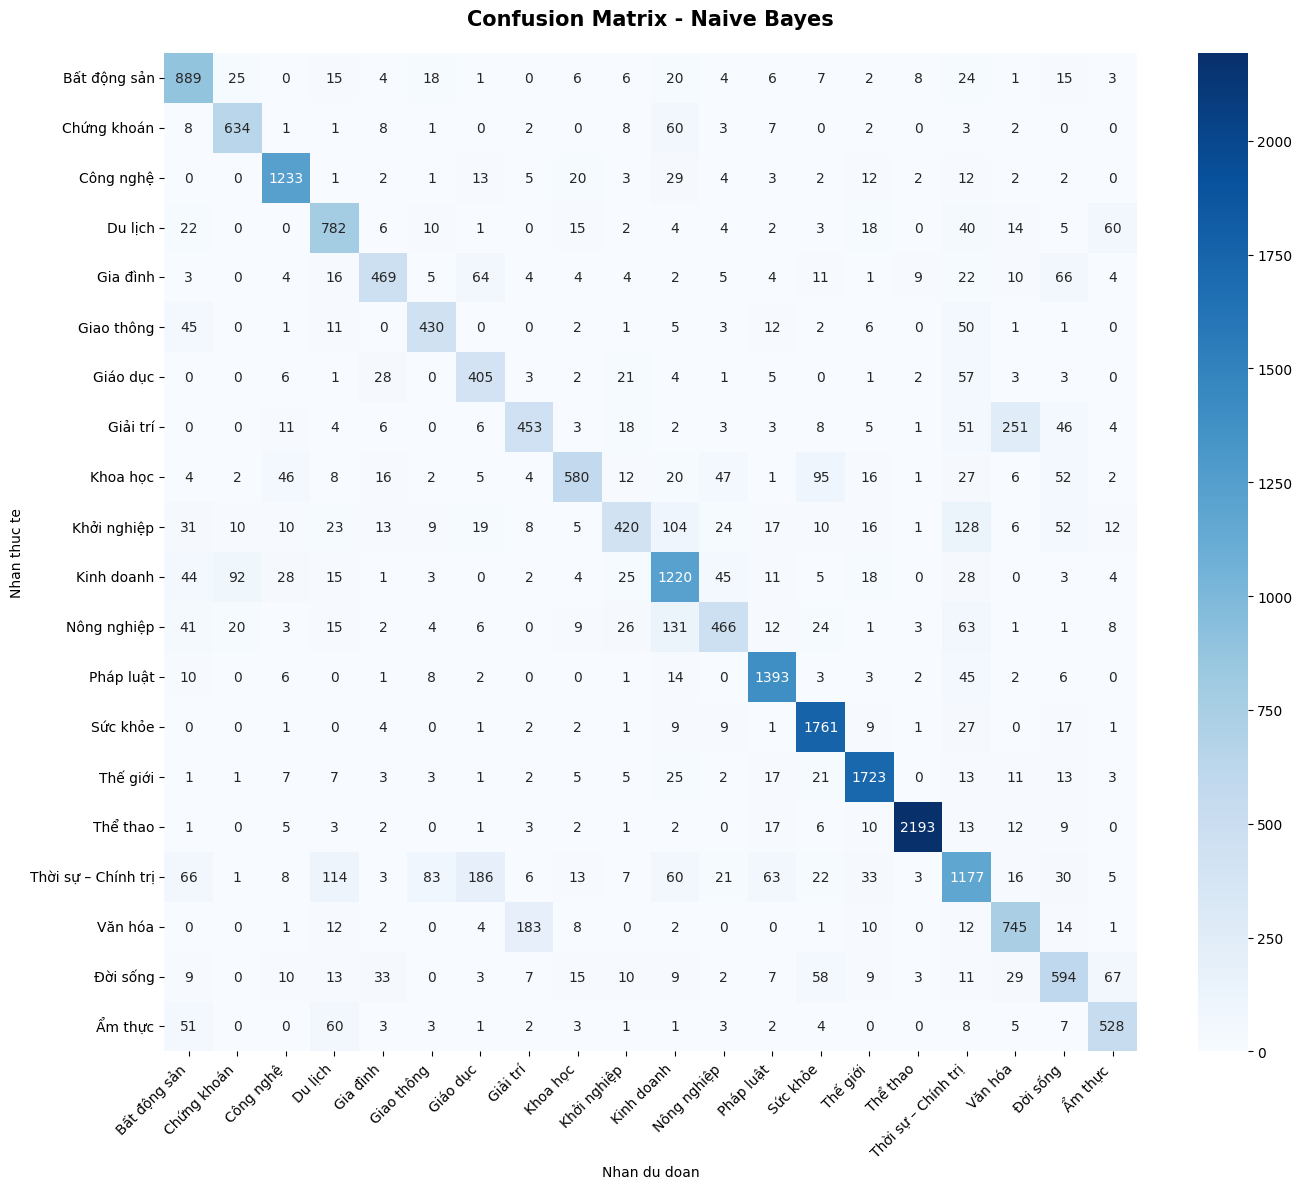

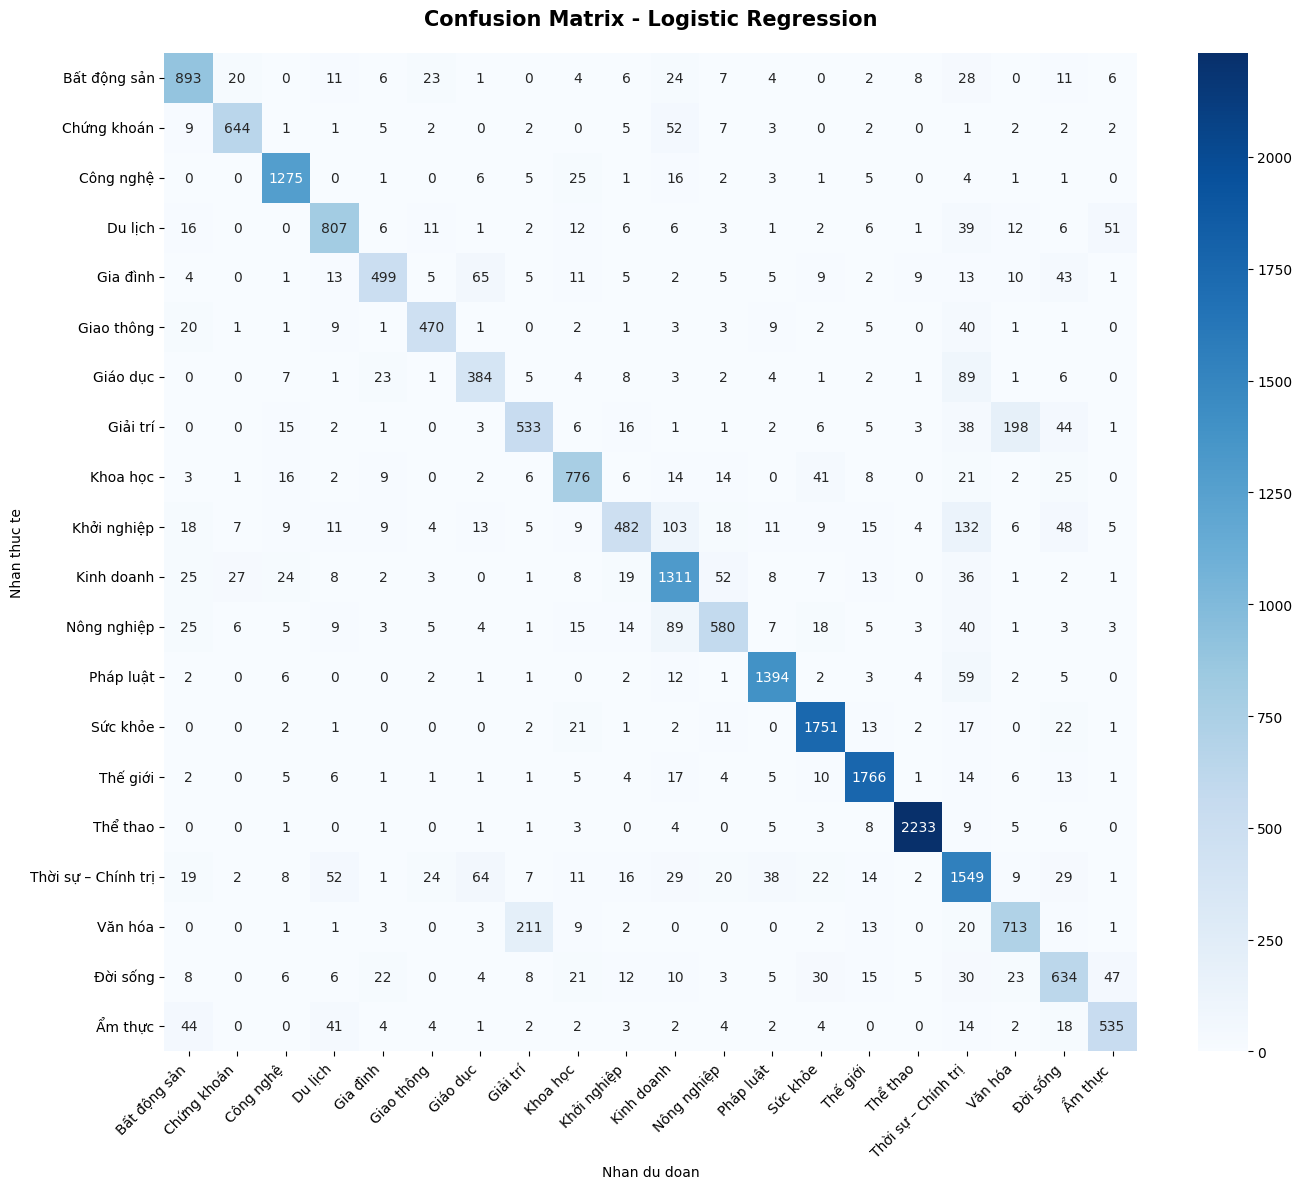

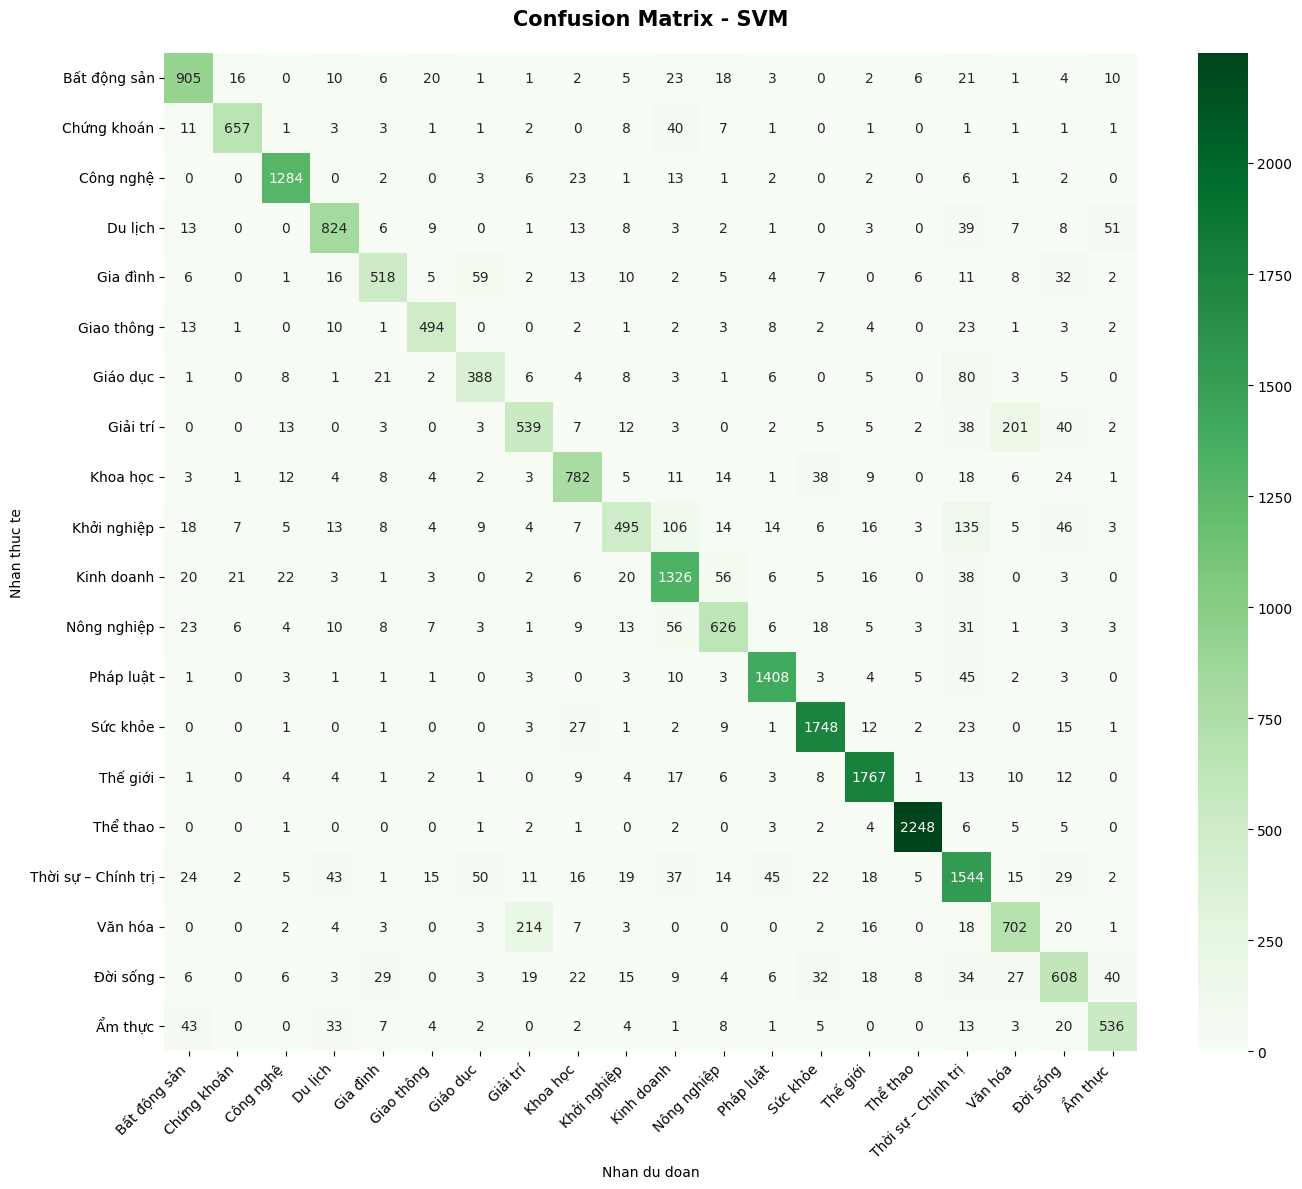

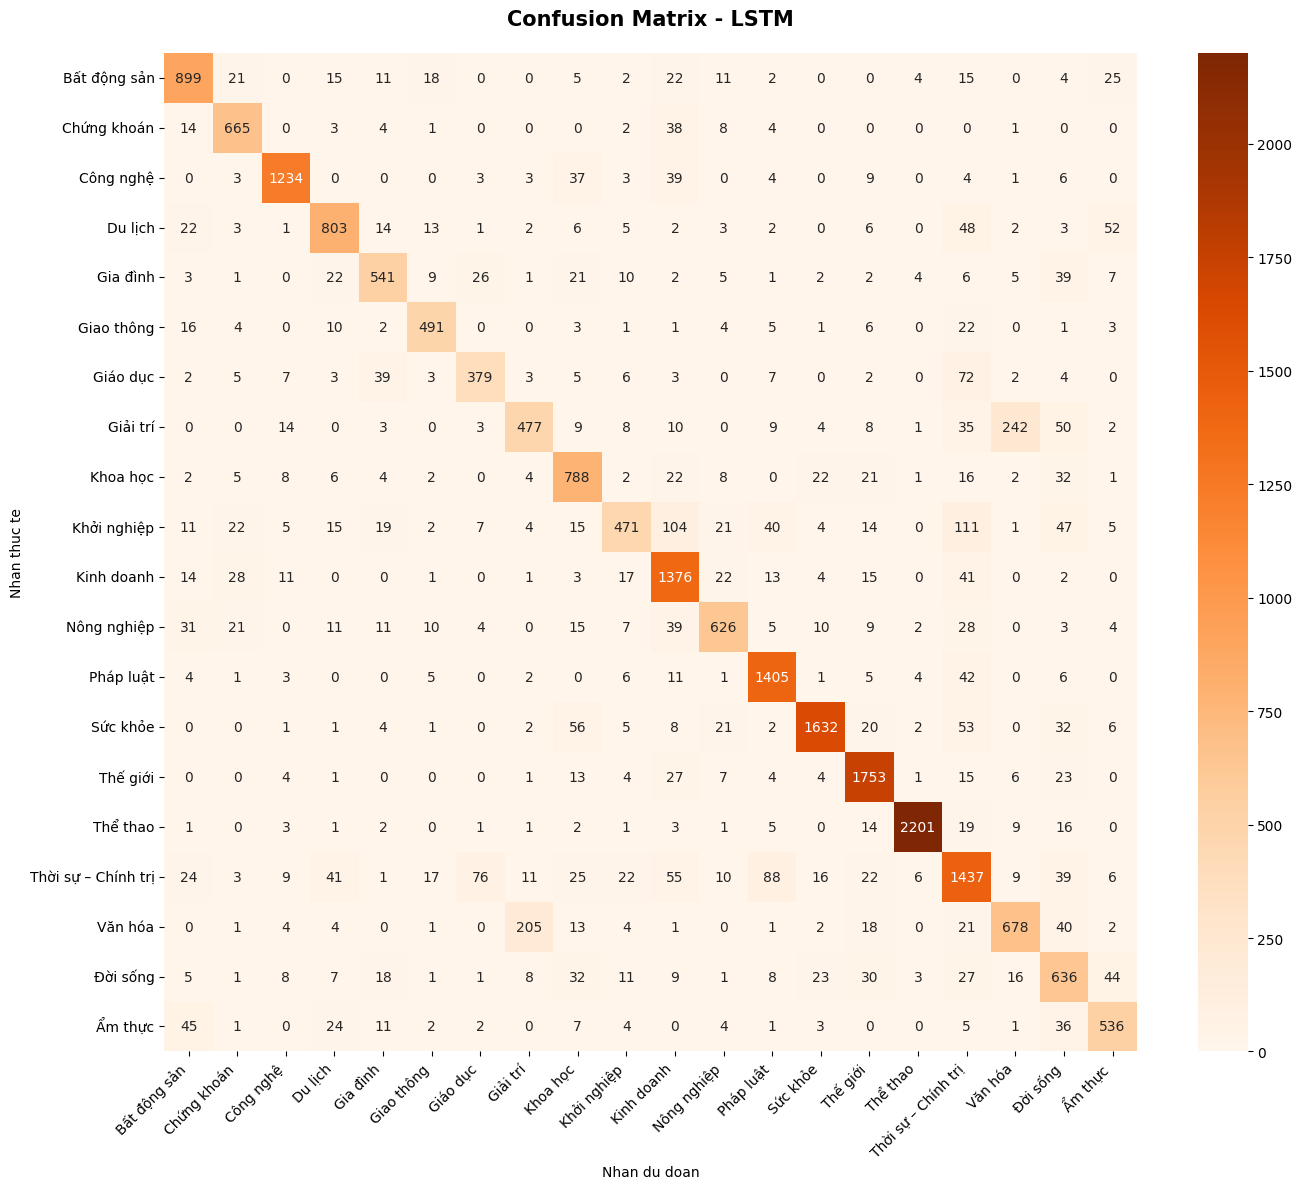

In [6]:
# ==============================================================================
# 6. DANH GIA CHI TIET & BAO CAO
# ==============================================================================
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import joblib
import torch

# --- 1. THU THAP DU DOAN ---
print("Dang thu thap ket qua du doan...")
model_preds = {}

# A. Machine Learning Predictions
if 'nb' in globals(): model_preds['Naive Bayes'] = nb.predict(X_test)
if 'lr' in globals(): model_preds['Logistic Regression'] = lr.predict(X_test)
if 'svm' in globals(): model_preds['SVM'] = svm.predict(X_test)

# B. Deep Learning Predictions
if 'preds_lstm' in globals():
    model_preds['LSTM'] = np.array(preds_lstm)
if 'preds_cnn' in globals() and len(preds_cnn) > 0:
    model_preds['TextCNN'] = np.array(preds_cnn)

# --- 2. TINH METRICS & LUU BAO CAO EXCEL ---
summary_data = []
report_path = REPORT_DIR / "detailed_classification_report.xlsx"
print(f"Dang xuat Excel report: {report_path.name}")

with pd.ExcelWriter(report_path) as writer:
    for model_name, y_pred in model_preds.items():
        acc = accuracy_score(test_df['label_id'], y_pred)
        summary_data.append({"Model": model_name, "Accuracy": acc})
        
        clf_report = classification_report(test_df['label_id'], y_pred, target_names=classes, output_dict=True)
        df_report = pd.DataFrame(clf_report).transpose()
        
        sheet_name = model_name[:31]
        df_report.to_excel(writer, sheet_name=sheet_name)

# --- 3. VE BIEU DO SO SANH ---
results_df = pd.DataFrame(summary_data).sort_values(by="Accuracy", ascending=False).reset_index(drop=True)

plt.figure(figsize=(10, 6))
sns.barplot(data=results_df, x="Accuracy", y="Model", palette="viridis", hue="Model", legend=False)
plt.title("So sanh do chinh xac giua cac mo hinh")
plt.xlim(0, 1.15)
plt.grid(axis='x', linestyle='--', alpha=0.7)

for i, row in results_df.iterrows():
    plt.text(row.Accuracy + 0.01, i, f"{row.Accuracy:.2%}", va='center', fontweight='bold', color='black')

plt.savefig(REPORT_DIR / "model_comparison.png", bbox_inches='tight')
plt.show()

print("Bang Xep Hang Hieu Nang:")
display(results_df)

# --- 4. VE CONFUSION MATRIX CHO TAT CA MODEL ---
print(f"Dang ve Confusion Matrix cho {len(model_preds)} mo hinh...")

for model_name, y_pred in model_preds.items():
    cm = confusion_matrix(test_df['label_id'], y_pred)
    
    plt.figure(figsize=(14, 12))
    
    color_map = 'Blues'
    if 'SVM' in model_name: color_map = 'Greens'
    if 'TextCNN' in model_name or 'CNN' in model_name: color_map = 'Purples'
    if 'LSTM' in model_name: color_map = 'Oranges'
    
    sns.heatmap(cm, annot=True, fmt='d', cmap=color_map, 
                xticklabels=classes, yticklabels=classes)
    
    plt.title(f"Confusion Matrix - {model_name}", fontsize=15, fontweight='bold', pad=20)
    plt.ylabel('Nhan thuc te')
    plt.xlabel('Nhan du doan')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    
    safe_name = model_name.replace(" ", "_")
    plt.savefig(REPORT_DIR / f"confusion_matrix_{safe_name}.png")
    # plt.show()

# --- 5. LUU TRU TAT CA MODEL ---
print("Dang luu cac mo hinh...")
if 'le' in globals(): joblib.dump(le, MODEL_DIR / "label_encoder.pkl")
if 'tfidf' in globals(): joblib.dump(tfidf, MODEL_DIR / "tfidf_vectorizer.pkl")
if 'nb' in globals(): joblib.dump(nb, MODEL_DIR / "naive_bayes.pkl")
if 'lr' in globals(): joblib.dump(lr, MODEL_DIR / "logistic_regression.pkl")
if 'svm' in globals(): joblib.dump(svm, MODEL_DIR / "svm_linear.pkl")

if 'model_lstm' in globals():
    lstm_checkpoint = {
        'vocab': vocab, 
        'model_state': model_lstm.state_dict(),
        'config': {
            'vocab_size': len(vocab)+2, 
            'embed_dim': 128,
            'hidden_dim': 256,
            'num_classes': num_classes, 
            'max_len': 500
        }
    }
    torch.save(lstm_checkpoint, MODEL_DIR / "lstm_model.pth")
    print(" - Da luu LSTM Model.")

if 'model_cnn' in globals():
    cnn_checkpoint = {
        'vocab': vocab,
        'model_state': model_cnn.state_dict(),
        'config': {
            'vocab_size': cnn_vocab_size,
            'embed_dim': cnn_embed_dim,
            'num_classes': num_classes,
            'kernels': cnn_kernels,
            'filters': cnn_filters,
            'max_len': 1024
        }
    }
    torch.save(cnn_checkpoint, MODEL_DIR / "textcnn_model.pth")
    print(" - Da luu TextCNN Model.")

print("Hoan tat toan bo quy trinh!")

# 7. HỆ THỐNG DỰ ĐOÁN THỰC TẾ (INFERENCE)

In [9]:

import torch
import torch.nn as nn
import joblib
import torch.nn.functional as F
import requests
import pandas as pd
from bs4 import BeautifulSoup
from pathlib import Path
from pyvi import ViTokenizer

# --- CẤU HÌNH ---
CURRENT_DIR = Path.cwd()
PROJECT_ROOT = CURRENT_DIR if (CURRENT_DIR / "data").exists() else CURRENT_DIR.parent
MODEL_DIR = PROJECT_ROOT / "models"
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f"Device: {DEVICE}")

# --- MODEL DEFINITIONS ---
class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_classes):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, num_layers=2, batch_first=True, dropout=0.3)
        self.fc = nn.Linear(hidden_dim, num_classes)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        embedded = self.embedding(x)
        output, (h_n, c_n) = self.lstm(embedded)
        out, _ = torch.max(output, dim=1)
        out = self.dropout(out)
        out = self.fc(out)
        return out

class TextCNN(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_classes, kernel_sizes=[2, 3, 4, 5, 6], num_filters=128):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        
        self.convs = nn.ModuleList([
            nn.Conv1d(in_channels=embed_dim, 
                      out_channels=num_filters, 
                      kernel_size=k) 
            for k in kernel_sizes
        ])
        
        self.bn = nn.BatchNorm1d(len(kernel_sizes) * num_filters)
        
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(len(kernel_sizes) * num_filters, num_classes)

    def forward(self, x):
        x = self.embedding(x) 
        x = x.permute(0, 2, 1) 
        
        # Conv -> ReLU -> MaxPool
        x_convs = [F.relu(conv(x)) for conv in self.convs]
        x_pools = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in x_convs]
        x_cat = torch.cat(x_pools, dim=1)
        x_cat = self.bn(x_cat)
        out = self.dropout(x_cat)
        return self.fc(out)

# --- LOAD MODELS ---
le, tfidf = None, None
nb, lr, svm = None, None, None
lstm_model, lstm_vocab, lstm_config = None, {}, {}
cnn_model, cnn_config = None, {}

try:
    if (MODEL_DIR / "label_encoder.pkl").exists(): le = joblib.load(MODEL_DIR / "label_encoder.pkl")
    if (MODEL_DIR / "tfidf_vectorizer.pkl").exists(): tfidf = joblib.load(MODEL_DIR / "tfidf_vectorizer.pkl")
    if (MODEL_DIR / "naive_bayes.pkl").exists(): nb = joblib.load(MODEL_DIR / "naive_bayes.pkl")
    if (MODEL_DIR / "logistic_regression.pkl").exists(): lr = joblib.load(MODEL_DIR / "logistic_regression.pkl")
    if (MODEL_DIR / "svm_linear.pkl").exists(): svm = joblib.load(MODEL_DIR / "svm_linear.pkl")

    # 2. LSTM
    if (MODEL_DIR / "lstm_model.pth").exists():
        ckpt = torch.load(MODEL_DIR / "lstm_model.pth", map_location='cpu')
        lstm_config, lstm_vocab = ckpt['config'], ckpt['vocab']
        
        lstm_model = LSTMClassifier(
            lstm_config.get('vocab_size', len(lstm_vocab) + 2),
            lstm_config.get('embed_dim', 128),
            lstm_config.get('hidden_dim', 256),
            lstm_config.get('num_classes', 20)
        )
        lstm_model.load_state_dict(ckpt['model_state'])
        lstm_model.to(DEVICE).eval()

    # 3. TextCNN
    if (MODEL_DIR / "textcnn_model.pth").exists():
        ckpt = torch.load(MODEL_DIR / "textcnn_model.pth", map_location='cpu')
        cnn_config = ckpt['config']
        
        cnn_model = TextCNN(
            cnn_config['vocab_size'], 
            cnn_config['embed_dim'], 
            cnn_config['num_classes'], 
            cnn_config['kernels'], 
            cnn_config['filters']
        )
        cnn_model.load_state_dict(ckpt['model_state'])
        cnn_model.to(DEVICE).eval()

except Exception as e:
    print(f"Load Error: {e}")

# --- PREDICT FUNCTION ---
def predict_all_models(url_or_text):
    print(f"\nInput: {url_or_text[:60]}...")
    
    # Get Content
    content = url_or_text
    if url_or_text.startswith("http"):
        try:
            headers = {'User-Agent': 'Mozilla/5.0'}
            resp = requests.get(url_or_text, headers=headers, timeout=10)
            soup = BeautifulSoup(resp.content, 'html.parser')
            content = ' '.join([p.get_text() for p in soup.find_all('p')])
            if len(content) < 50: return print("Short content.")
        except: return print("URL Error.")

    # Preprocess
    text_seg = ViTokenizer.tokenize(content)
    
    print("-" * 65)
    print(f"{'MODEL':<20} | {'LABEL':<30} | {'CONF'}")
    print("-" * 65)

    # 1. ML Predict
    if tfidf and le:
        vec = tfidf.transform([text_seg])
        
        if nb:
            print(f"{'Naive Bayes':<20} | {le.inverse_transform(nb.predict(vec))[0].upper():<30} | {nb.predict_proba(vec).max():.2%}")
        if lr:
            print(f"{'Logistic Reg':<20} | {le.inverse_transform(lr.predict(vec))[0].upper():<30} | {lr.predict_proba(vec).max():.2%}")
        if svm:
            p = f"{svm.predict_proba(vec).max():.2%}" if hasattr(svm, "predict_proba") else "N/A"
            print(f"{'SVM':<20} | {le.inverse_transform(svm.predict(vec))[0].upper():<30} | {p}")

    # 2. LSTM Predict
    if lstm_model and lstm_vocab:
        max_len = lstm_config.get('max_len', 800)
        seq = [lstm_vocab.get(w, 1) for w in text_seg.split()]
        seq = (seq + [0]*(max_len-len(seq)))[:max_len]
        
        with torch.no_grad():
            out = lstm_model(torch.tensor([seq], dtype=torch.long).to(DEVICE))
            prob, idx = torch.max(torch.softmax(out, dim=1), dim=1)
            print(f"{'LSTM':<20} | {le.inverse_transform([idx.item()])[0].upper():<30} | {prob.item():.2%}")

    # 3. TextCNN Predict
    if cnn_model:
        max_len = cnn_config.get('max_len', 1024)
        seq = [lstm_vocab.get(w, 1) for w in text_seg.split()] # Use same vocab
        seq = (seq + [0]*(max_len-len(seq)))[:max_len]
        
        with torch.no_grad():
            out = cnn_model(torch.tensor([seq], dtype=torch.long).to(DEVICE))
            prob, idx = torch.max(torch.softmax(out, dim=1), dim=1)
            print(f"{'TextCNN':<20} | {le.inverse_transform([idx.item()])[0].upper():<30} | {prob.item():.2%}")
    
    print("-" * 65)

# --- TEST ---
link_test = "https://vnexpress.net/nu-sinh-gianh-hc-vang-sea-games-duoc-truong-thuong-hon-100-trieu-dong-4996452.html"
predict_all_models(link_test)

Device: cuda

Input: https://vnexpress.net/nu-sinh-gianh-hc-vang-sea-games-duoc-t...
-----------------------------------------------------------------
MODEL                | LABEL                          | CONF
-----------------------------------------------------------------
Naive Bayes          | THỂ THAO                       | 39.48%
Logistic Reg         | GIA ĐÌNH                       | 33.86%
SVM                  | THỂ THAO                       | 54.60%
LSTM                 | GIA ĐÌNH                       | 90.00%
TextCNN              | GIÁO DỤC                       | 80.70%
-----------------------------------------------------------------
